In [6]:
import time
import warnings

from sklearn import cluster, datasets, decomposition, mixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Basics / Mathematics

### Example 1
This is a basic example that can be used to introduce any clustering algorithm in particular (the default is set to KMeans right now).

The first unsupervised problem we will study in this course involves the clustering of widely separated 'blobs' of data, a simplified version of what scientists obtain through experiment. There are several methods for this clustering to be achieved, the most rudimentary being KMeans...Using the default parameters defined below, create 4 widely-separated blobs of data in 10-dimensional space, and observe how KMeans clusters each point in the plot of the first two dimensions below. 

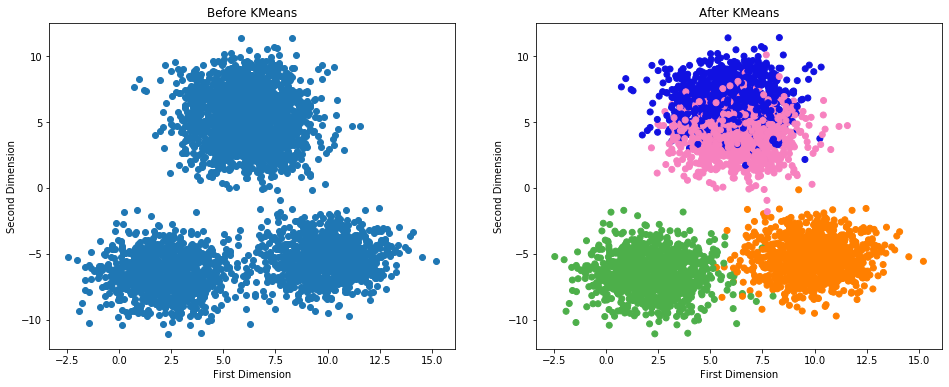

In [83]:
n_clusters = 4 # The number of clusters
n_points = 1000 # The number of points in each cluster
n_dimensions = 10 # The number of dimensions
standard_dev = 1.5 # The standard deviation of each cluster

#########################################################################################################################################################################

data, real_labels = datasets.make_blobs(n_samples=n_clusters*n_points, centers=n_clusters, n_features=n_dimensions, cluster_std=standard_dev, random_state=111)

# Cluster the data
clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=111)
cluster_labels = clusterer.fit_predict(data)

# Plot
fig = plt.figure(figsize=(16,6))

colors = np.array(list(islice(cycle(['#1111e1', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']), int(max(cluster_labels) + 1))))
colors = np.append(colors, ["#000000"])

ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel('First Dimension')
ax1.set_ylabel('Second Dimension')
ax1.scatter(data[:,0], data[:,1])
plt.title('Before KMeans')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel('First Dimension')
ax2.set_ylabel('Second Dimension')
ax2.scatter(data[:,0], data[:,1], c=colors[cluster_labels])
plt.title('After KMeans')

plt.show()

Were you able to cluster the data into 4 'blobs' by yourself (using just the first two dimensions)? (Maybe explain PCA and plot again). KMeans requires an n_cluster input value, but what about methods that don't? Would they have still found 4 clusters? 

### Example 2
This is a basic implementation of silhouette analysis for cluster verification/scoring. Inspired by https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Now that we know how a few clustering algorithms work, How do we assess the validity of the proposed clusters? One of the most prominent methods of cluster verification is known as silhouette analysis, where each data point is assigned a score from -1 to +1 assessing how well it was clustered. Taking the average of this score, we have a quantitative measure of how well our clustering technique has performed. The example below inputs various n_cluster values into KMeans and determines the average silhouette value for each run:

For n_clusters = 3 The average silhouette_score is : 0.5299147299149848
For n_clusters = 4 The average silhouette_score is : 0.6163692754493503
For n_clusters = 5 The average silhouette_score is : 0.7203206285735181
For n_clusters = 6 The average silhouette_score is : 0.5810535830635365
For n_clusters = 7 The average silhouette_score is : 0.46017417426914464


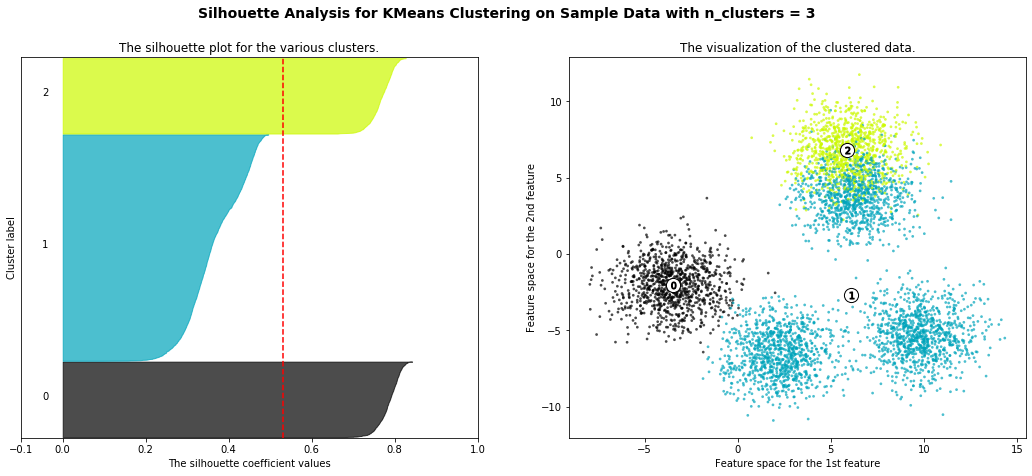

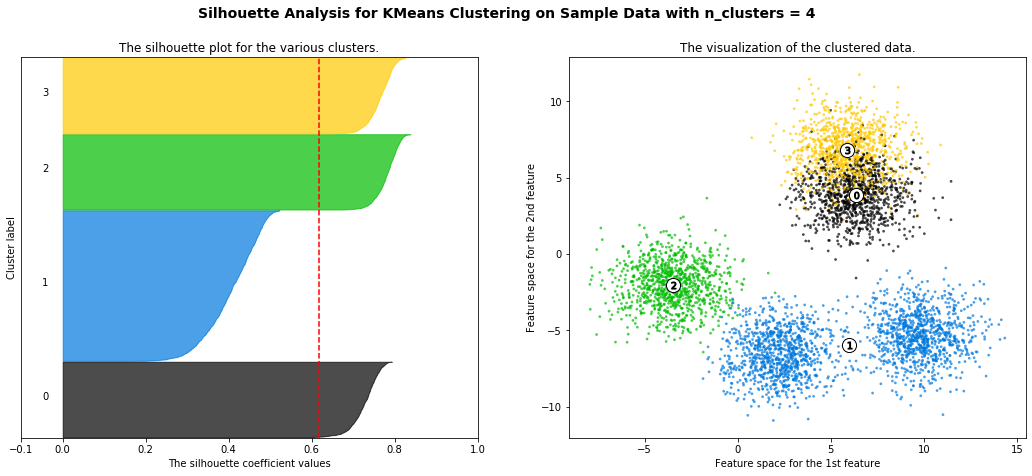

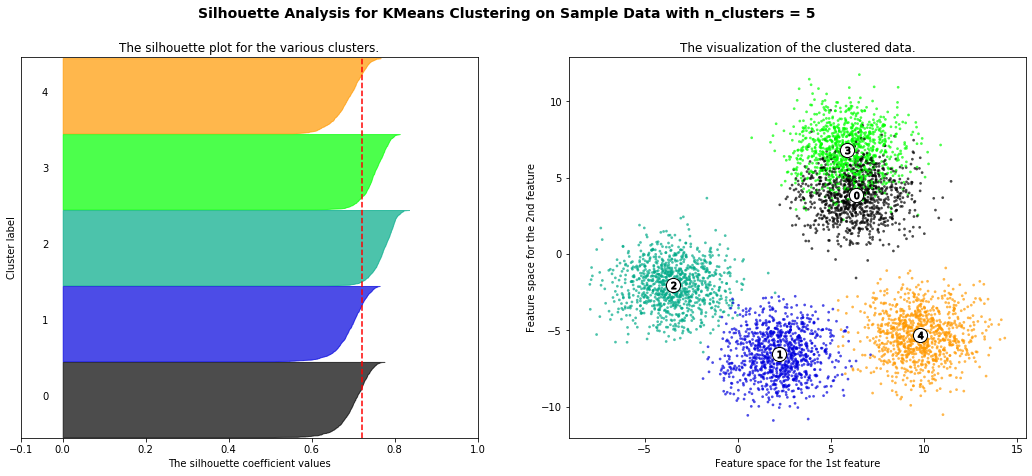

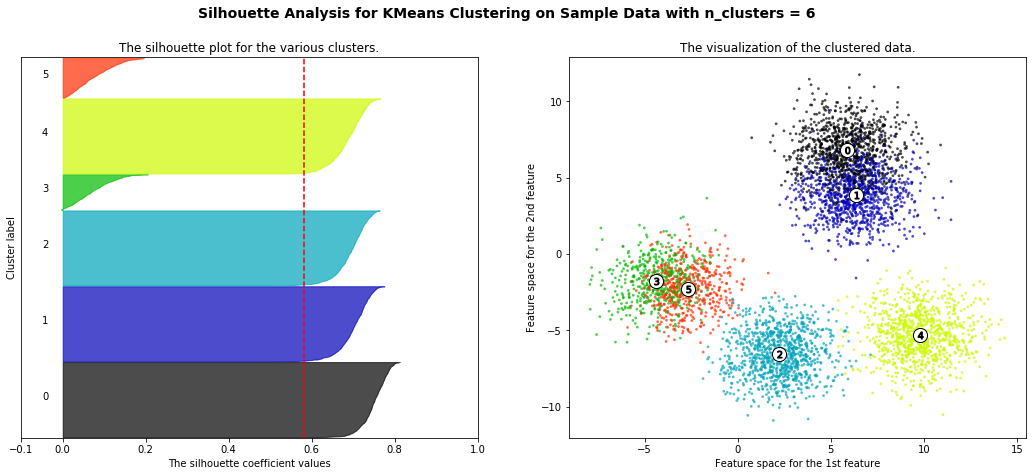

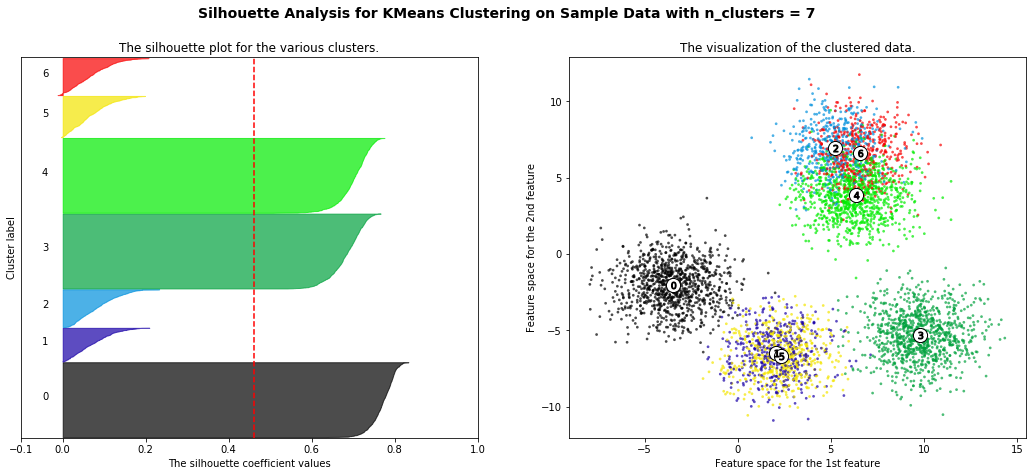

In [84]:
n_clusters = 5 # The number of clusters
n_points = 1000 # The number of points in each cluster
n_dimensions = 10 # The number of dimensions
standard_dev = 1.5 # The standard deviation of each cluster

range_n_clusters = [3, 4, 5, 6, 7] # The number of clusters to test

#########################################################################################################################################################################

data, real_labels = datasets.make_blobs(n_samples=n_clusters*n_points, centers=n_clusters, n_features=n_dimensions, cluster_std=standard_dev, random_state=111)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The first subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(data)

    # The silhouette_score gives the average value for all the samples. This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(data, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data[:, 0], data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette Analysis for KMeans Clustering on Sample Data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Which n_cluster value resulted in the largest average silhouette value? Does this match your expecations? Will this always work?

### Example 3
This example serves as a comparison of how different clustering algorithms perform on toy data sets

Inspired by https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

There are of course tons of clustering algorithms we won't be able to discuss in detail, each with its own pros/cons for particular data types/shapes/styles. The following example compares how common clustering algorithms perform on 6 different data sets. 

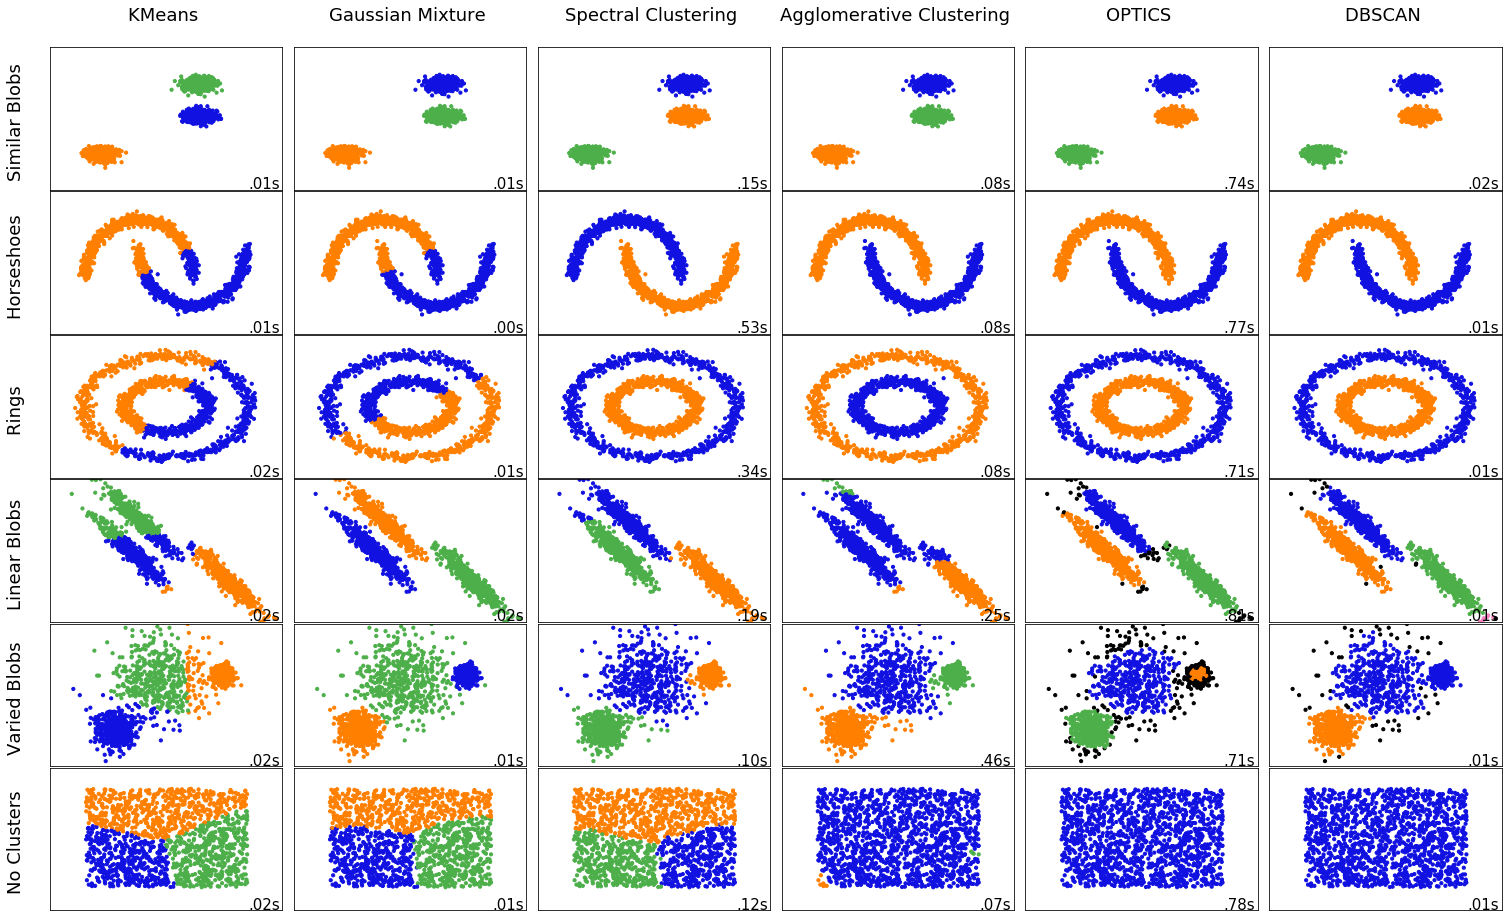

In [68]:
#######################################################################################################################################################
np.random.seed(0)

# Generate datasets
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

# Set up cluster parameters
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

plot_num = 1

default_base = {'quantile': .3, 'eps': .3, 'damping': .9, 'preference': -200, 'n_neighbors': 10, 
                'n_clusters': 3, 'min_samples': 20, 'xi': 0.05, 'min_cluster_size': 0.1}

data = [
    (blobs, {}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(data):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Create cluster objects
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('KMeans', two_means),
        ('Gaussian Mixture', gmm),
        ('Spectral Clustering', spectral),
        ('Agglomerative Clustering', average_linkage),
        ('OPTICS', optics),
        ('DBSCAN', dbscan)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(data), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name + " \n", size=18)
        if i_dataset == 0 and name == "KMeans":
            plt.ylabel('Similar Blobs \n', size=18)
        if i_dataset == 1 and name == "KMeans":
            plt.ylabel('Horseshoes \n', size=18)
        if i_dataset == 2 and name == "KMeans":
            plt.ylabel('Rings \n', size=18)
        if i_dataset == 3 and name == "KMeans":
            plt.ylabel('Linear Blobs \n', size=18)
        if i_dataset == 4 and name == "KMeans":
            plt.ylabel('Varied Blobs \n', size=18)
        if i_dataset == 5 and name == "KMeans":
            plt.ylabel('No Clusters \n', size=18)

        colors = np.array(list(islice(cycle(['#1111e1', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

Which of these performed the worst? The best? Can you explain why you would expect failures for some of these algorithms? Which of these tests would you expect is clostest to experimental data? 

# Chemistry Example

### Aerosol Classification from Spectral UV Measurements Using Machine Learning Clustering

Inspired by https://www.mdpi.com/2072-4292/12/6/965